In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_IT.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IT/functions_IT_v2.ipynb

# 1. Data Loading

In [5]:
ds = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_igw/ssh_igw_*.nc",combine='nested',concat_dim='time_counter',parallel=True)

In [6]:
time_start = '2014-05-01 00:30'
#time_end = '2014-05-30 23:30'
time_end = '2014-07-31 23:30'
ds = ds.sel(time_counter=slice(time_start, time_end)).load()

In [7]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:       (time_counter: 2208, y: 853, x: 788)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 18kB 2014-05-01T00:30:00 ... ...
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x
Data variables:
    ssh_igw       (time_counter, y, x) float64 12GB 0.006768 ... -0.02028

# 2. Internal Tide Extraction

In [3]:
array_time = ds.ssh_igw.time_counter.values
nt = array_time.size

## Temporal Window

- Array Initialization of ones with lenght **3 * nt**.
- `gaspari_cohn` functions creates a Gaspari-Cohn window using an array ranging from **0 to 2 * nt - 1, with a center at nt and a distance of nt**.
- Apply `gaspari_cohn` to both sides.

In [4]:
wint = np.ones(3*nt) # Initialize wint array with ones, of size 3 * nt
gaspari = gaspari_cohn(np.arange(0,2*nt,1),nt,nt) # Generate Gaspari-Cohn window
wint[:nt]=gaspari[:nt] # Apply the first half of Gaspari-Cohn values to the first third of wint
wint[2*nt:]=gaspari[nt:] # Apply the second half of Gaspari-Cohn values to the last third of wint

## Frequency Filtering Parameters

- Time step Initialization: set the time step **dt** to 3600 seconds (1 hour).
- Frequency array:
  - `w = fp.fftfreq(3 * nt, dt)` generates the frequency bins for a signal of length **3 * nt** with a time step dt.
  - `nw = w.size` stores the number of frequency bins in **nw**.
- Frequency Range for Filtering
  - Calculates the lower bound frequency for a period of 15 hours.
  - Calculates the lower bound frequency for a period of 9 hours.
- Create Frequency Mask
  - `H = (np.abs(w) > w1)` & `(np.abs(w) < w2)` creates a boolean mask where frequencies within the desired range (w1 to w2) are True.
- Apply Frequency Mask
  - `w_filtered = H * w` filters the frequency array, retaining only the frequencies within the specified range.

In [5]:
# Frequency filtering
dt = 3600 # Time step in seconds (1 hour)

w = fp.fftfreq(3*nt,dt) # Generate frequency array for FFT in seconds^-1
nw = w.size # Size of the frequency array

w1 = 1/15/3600 # Lower frequency bound (15 hours period)
w2 = 1/9/3600 # Upper frequency bound (9 hours period)
H = (np.abs(w)>w1) & (np.abs(w)<w2) # Create a boolean mask for frequencies within the desired range
w_filtered = H*w # Apply the mask to the frequency array

In [6]:
idx_ocean = np.where(np.invert(np.isnan(ds.ssh_igw[0,:,:].values))) # indexes of ocean pixels 

## Filtering (Extraction of Internal Tides)

`extract_it` function:
- Convert input to a numpy array.
- Extends the SSH array by concatenating the flipped array, the original array, and the flipped array again. This extension helps reduce edge effects when applying the FFT.
- Apply the window array **w1**.
- Compute the Fast Fourier Transform.
- Apply the bolean mask **H**.
- Compute the inverse fourier Transform.

In [7]:
ssh_it_flat = np.array(Parallel(n_jobs=-1,backend='multiprocessing')(delayed(extract_it)(ds.ssh_igw[:,i,j],wint,H) for i,j in zip(idx_ocean[0],idx_ocean[1])))

In [ ]:
array_ssh_it = np.nan*np.ones_like(ds.ssh_igw.values,dtype="float64")
array_ssh_it[:,idx_ocean[0],idx_ocean[1]]=ssh_it_flat.T

In [ ]:
# np.save(file="/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it_2014.npy",arr=array_ssh_it)

In [2]:
array_ssh_it=np.load("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it.npy")

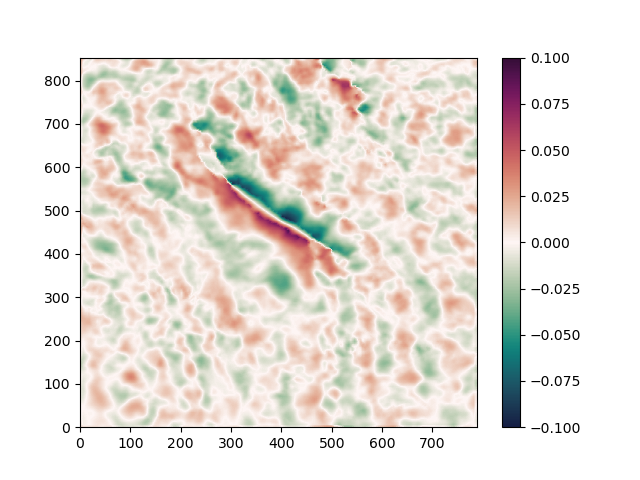

In [3]:
plt.figure()
plt.pcolormesh(array_ssh_it[200,:,:],cmap=cmocean.cm.curl, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

NameError: name 'ds' is not defined

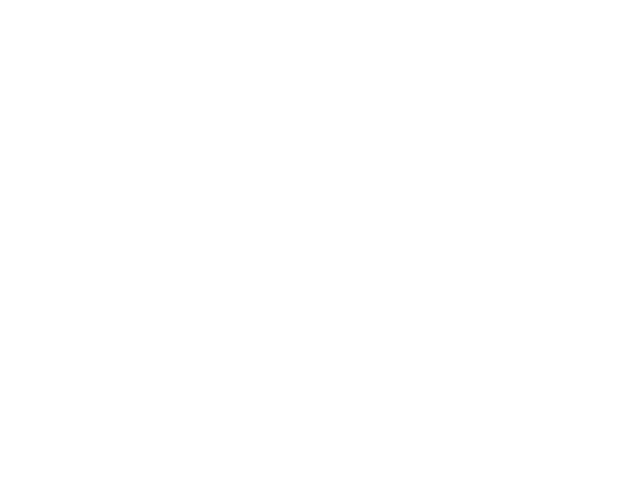

In [4]:
plt.figure()
plt.pcolormesh(ds.ssh_igw[200,:,:],cmap=cmocean.cm.curl, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

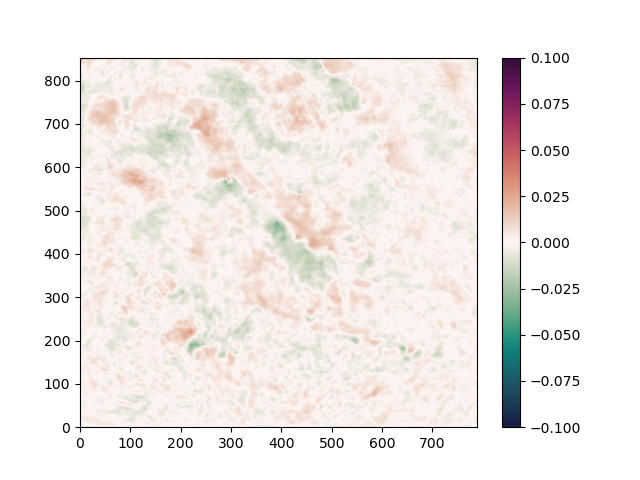

In [ ]:
plt.figure()
plt.pcolormesh(ds.ssh_igw[200,:,:]-array_ssh_it[200,:,:],cmap=cmocean.cm.curl, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

In [9]:
time_counter = ds.time_counter
nav_lat = ds.nav_lat.data
nav_lon = ds.nav_lon.data

# Creating a new xarray.Dataset with ssh_it
ssh_it = xr.Dataset(
    {
        "ssh_it": (["time_counter", "y", "x"], array_ssh_it)
    },
    coords={
        "time_counter": time_counter,
        "nav_lat": (["y", "x"], nav_lat),
        "nav_lon": (["y", "x"], nav_lon)
    }
)

In [10]:
ssh_it

<xarray.Dataset> Size: 12GB
Dimensions:       (time_counter: 2208, y: 853, x: 788)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 18kB 2014-05-01T00:30:00 ... ...
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x
Data variables:
    ssh_it        (time_counter, y, x) float64 12GB 0.0009882 ... -0.02477

In [24]:
save_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/"

# Define the time range for each month, ensuring the end time is included up to 23:00
time_ranges = {
    "05": ("2014-05-01 00:30", "2014-05-31 23:30"),
    "06": ("2014-06-01 00:30", "2014-06-30 23:30"),
    "07": ("2014-07-01 00:30", "2014-07-31 23:30")
}

# Iterate over each time range and save the corresponding data
for month, (start_date, end_date) in time_ranges.items():
    # Select the data for the given time range
    ssh_it_month = ssh_it.sel(time_counter=slice(start_date, end_date))
    
    # Define the filename
    filename = f"ssh_it_{month}.nc"
    
    # Save the dataset to a NetCDF file
    ssh_it_month.to_netcdf(save_path + filename)
    
    print(f"Saved {filename} to {save_path}")

Saved ssh_it_05.nc to /bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/
Saved ssh_it_06.nc to /bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/
Saved ssh_it_07.nc to /bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/


In [35]:
ssh_it_05 = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it_05.nc")
ssh_it_06 = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it_06.nc")
ssh_it_07 = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it_07.nc")

In [37]:
print("Mayo")
print("First date:", ssh_it_05.time_counter[0].values)
print("Last date:", ssh_it_05.time_counter[-1].values)
print("Number of time steps:", ssh_it_05.time_counter.size)
print("Junio")
print("First date:", ssh_it_06.time_counter[0].values)
print("Last date:", ssh_it_06.time_counter[-1].values)
print("Number of time steps:", ssh_it_06.time_counter.size)
print("Julio")
print("First date:", ssh_it_07.time_counter[0].values)
print("Last date:", ssh_it_07.time_counter[-1].values)
print("Number of time steps:", ssh_it_07.time_counter.size)

Mayo
First date: 2014-05-01T00:30:00.000000000
Last date: 2014-05-31T23:30:00.000000000
Number of time steps: 744
Junio
First date: 2014-06-01T00:30:00.000000000
Last date: 2014-06-30T23:30:00.000000000
Number of time steps: 720
Julio
First date: 2014-07-01T00:30:00.000000000
Last date: 2014-07-31T23:30:00.000000000
Number of time steps: 744
